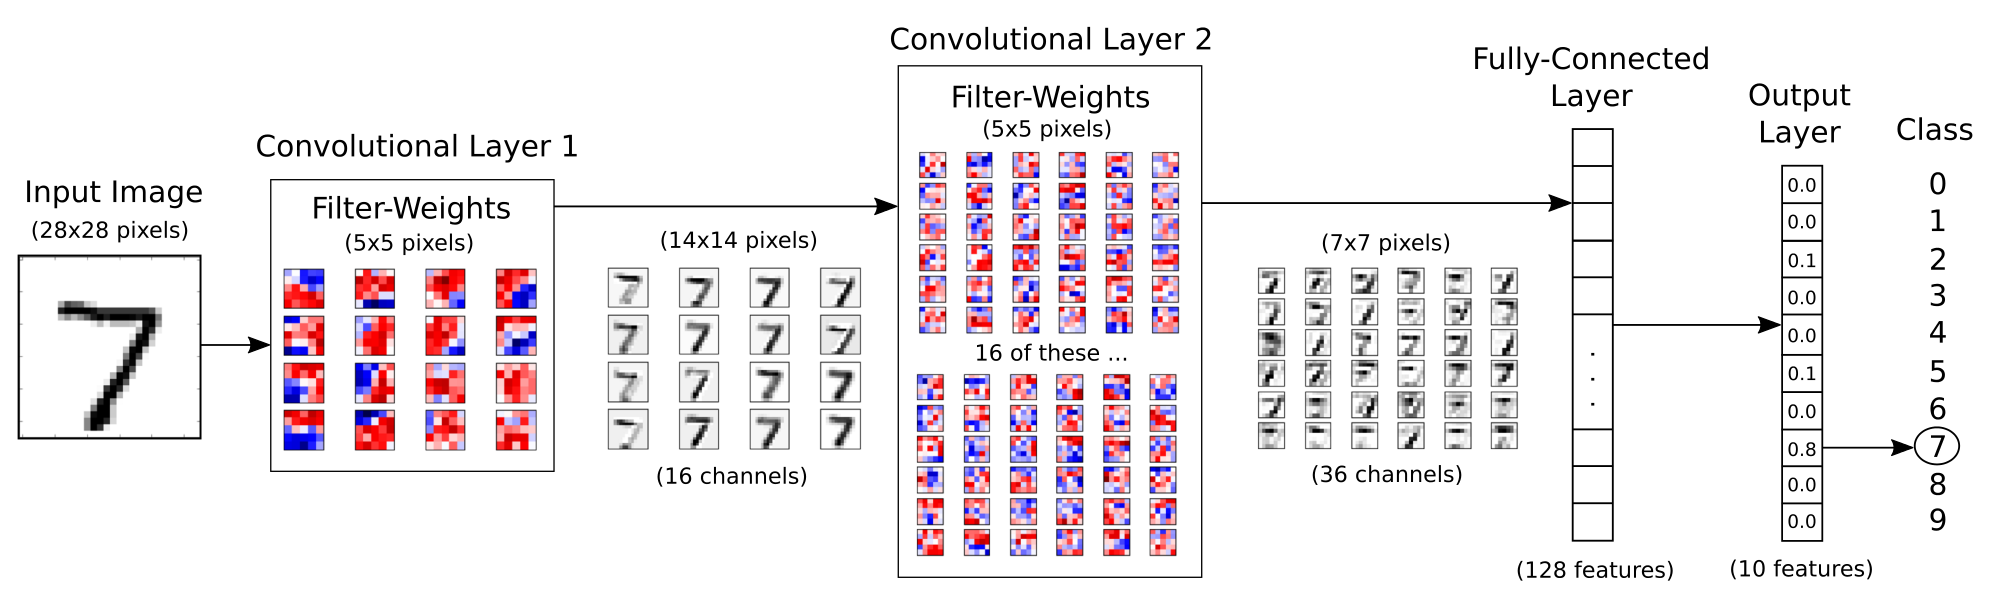

In [1]:
from IPython.display import Image
Image('images/02_network_flowchart.png')

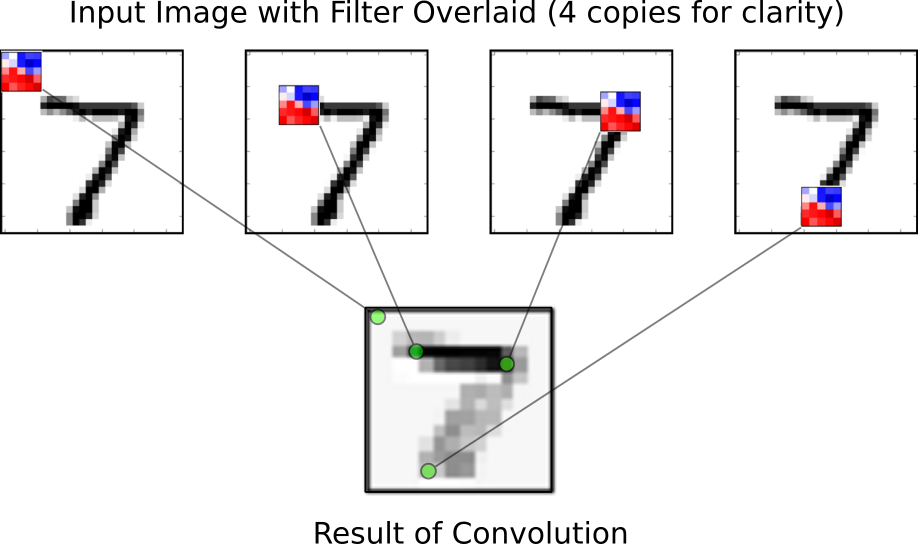

In [2]:
Image('images/02_convolution.png')

   # Imports

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [4]:
tf.__version__

'0.11.0'

## Configuration of Neural Network

In [5]:
#convolutional layer 1
filter_size1 = 5
num_filters1 = 16

#convolutional layer 2
filter_size2 = 5
num_filters2 = 36

#fully-connected layer
fc_size = 128  #number of neurons in fully-connected layer


## Load Data

In [6]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MINST/',one_hot=True)

Extracting data/MINST/train-images-idx3-ubyte.gz
Extracting data/MINST/train-labels-idx1-ubyte.gz
Extracting data/MINST/t10k-images-idx3-ubyte.gz
Extracting data/MINST/t10k-labels-idx1-ubyte.gz


In [7]:
print("size of :")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))


size of :
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [8]:
#the class-tables are one-hot encoded, wich means each label is a vector
#with 10 elements, one of them is 1 others are 0, the index of this 1 is 
#class-number as integers
data.test.cls = np.argmax(data.test.labels,axis=1)

## Data Dimensions

In [9]:
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_channels = 1   # 1 channel for gray scale 
num_classes = 10

### Helper function for plotting images

In [54]:
# Plot 9 images in 3*3 grid, write the true and predicted classes below each images
def plot_images(images,cls_true,cls_pred=None):
    assert len(images) == len(cls_true) ==9
    
    fig,axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3,wspace=0.3)
    
    for i,ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape),cmap='binary')
        
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i],cls_pred[i])
        
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

###  Plot a few images to see if data is correct

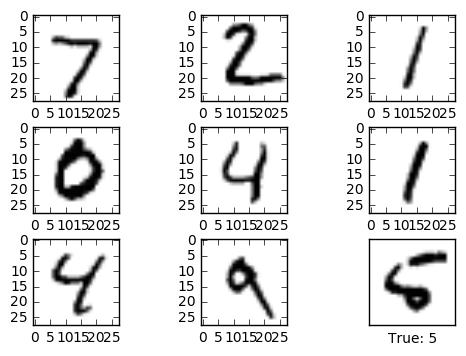

In [11]:
images = data.test.images[0:9]

cls_true = data.test.cls[0:9]

plot_images(images=images,cls_true=cls_true)

### Helper functions for creating new variables

In [12]:
#Outputs random values from a truncated normal distribution
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape,stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05,shape=[length]))

### Helper function for creating a new convolutional layer

In [13]:
def new_conv_layer(input,
                   num_input_channels,
                   filter_size,
                   num_filters,
                   use_pooling=True):
    # input-the previous layer  
    # num_input_channels-num. channels in prev. layer

    #shape of the filter-weights for the convolution
    shape = [filter_size, filter_size,num_input_channels,num_filters]

    #create new weights with the given shape
    weights = new_weights(shape=shape)

    #create new biases,one for each filter
    biases = new_biases(length=num_filters)

    #strides:the first is for the image-number and
    # the last is for the input-channel.
    layer = tf.nn.conv2d(input=input,
                     filter=weights,
                     strides=[1,1,1,1],
                     padding='SAME')

    #Add the biases to the results of the convolution
    #A bias-value is added to each filter-channel
    layer += biases

    # use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2*2 max-pooling
        layer = tf.nn.max_pool(value=layer,
                           ksize=[1,2,2,1],
                           strides=[1,2,2,1],
                           padding='SAME')

    #rectified linear unit (ReLU)
    #It calculates max(x,0) for each input pixel x
    #this adds some non-linearity to the formula and allow
    #us to learn more complicated functions
    layer = tf.nn.relu(layer)
    
    #note that ReLU is normally executed before the pooling,
    #but since relu(max_pool(x)) == max_pool(relu(x)) we can
    #save 75% of the relu-operations by max-pooling first
    
    #we return both the resulting layer and the filter-weights
    #because we will plot the weights later.
    return layer,weights


### Helper function for flattening a layer

In [14]:
def flatten_layer(layer):
    # get the shape of the input layer
    layer_shape = layer.get_shape()
    
    #the shape of the input layer is assumed to be:
    #layer_shape == [num_images,img_height,img_width,num_channels]
    
    #the number of features is :img_height*img_width*num_channels
    #we can use a function from tensorflow to calculate this
    num_features = layer_shape[1:4].num_elements()
    
    #reshape the layer to[num_images,num_features]
    #note that we just set the size of the second dimension
    #to num_features and the size of the fierst dimension to -1
    #which means the size in that dimension is calculated
    #so the total size of the tensor is unchanged from the reshaping
    layer_flat = tf.reshape(layer,[-1,num_features])
    
    
    # the shape of the flattedn layer is now:
    # [num_images,img_height*img_width*num_channels]
    return layer_flat,num_features
    

### Helper-function for creating a new fully-connected layer

In [15]:
def new_fc_layer(input,
                 num_inputs,
                 num_outputs,
                 use_relu=True):
    #creates new weights and biase
    weights = new_weights(shape=[num_inputs,num_outputs])
    biases = new_biases(length=num_outputs)
    
    #calculate the layer as the matrix multiplication of 
    #the input and weights, and then add the bias-values
    layer = tf.matmul(input,weights) + biases
    
    #use relu?
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

### Placeholder variables

In [16]:
#input images
x = tf.placeholder(tf.float32,shape=[None,img_size_flat],name='x')

In [17]:
# The convolutional layers expect x to be encoded as a 4-dim tensor
# num_images can be inferred automatically by using -1 for the size of the first dimension
x_image = tf.reshape(x,[-1,img_size,img_size,num_channels])

In [18]:
#placeholder variable for the true labels
y_true = tf.placeholder(tf.float32,shape=[None,10],name='y_true')

In [19]:
y_true_cls=tf.argmax(y_true,dimension=1)

### convolutional Layer 1

In [20]:
layer_conv1,weights_conv1 = new_conv_layer(input=x_image,
                     num_input_channels=num_channels,
                     filter_size=filter_size1,
                     num_filters=num_filters1,
                     use_pooling=True)

In [21]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

### Convolutional Layer 2

In [22]:
layer_conv2,weights_conv2 = \
      new_conv_layer(input=layer_conv1,
                     num_input_channels=num_filters1,
                     filter_size=filter_size2,
                     num_filters=num_filters2,
                     use_pooling=True)

In [23]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

### Flatten Layer

In [24]:
layer_flat,num_features = flatten_layer(layer_conv2)

In [25]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [26]:
num_features

1764

### Fully-connected Layer 1

In [27]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [28]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

### Fully-connected Layer 2

In [29]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [30]:
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

### Predicted Class

In [31]:
#softmax
y_pred = tf.nn.softmax(layer_fc2)

In [32]:
y_pred_cls = tf.argmax(y_pred,dimension=1)

### Cost- function to be optimized

In [33]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

In [34]:
cost = tf.reduce_mean(cross_entropy)

### Optimized Method

In [35]:
#We use the advanced form of gradient descent
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

### Performance Measures

In [36]:
correct_prediction = tf.equal(y_pred_cls,y_true_cls)

In [37]:
#change the booleans to floats, true-1,false=0
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

## TensorFlow run
### Create Tensorflow session

In [38]:
session = tf.Session()

In [39]:
session.run(tf.initialize_all_variables())

### Helper function to perform optimization iterations

In [40]:
#There are 55,000 images in the training-set. 
#It takes a long time to calculate the gradient of 
#the model using all these images. 
#We therefore only use a small batch of images in 
#each iteration of the optimizer.
train_batch_size = 64

In [41]:
#Function for performing a number of optimization iterations
#so as to gradually improve the variables of the 
#network layers. In each iteration, a new batch of 
#data is selected from the training-set and 
#then TensorFlow executes the optimizer using those 
#training samples. The progress is printed every 
#100 iterations.

total_iterations =0  # counter for total number of iterations performed so far

def optimize(num_iterations):
    #Ensure we update the global varibale rather than a local copy
    global total_iterations
    
    start_time = time.time()
    
    for i in range(total_iterations,total_iterations+num_iterations):
        # Get a batch of training examples.
        x_batch,y_true_batch = data.train.next_batch(train_batch_size)
        
        # put the batch into a dict wiht the proper names
        feed_dict_train = {x:x_batch,y_true:y_true_batch}
        
        # Run the optimizer using this batch of training data
        # Tensorflow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer
        session.run(optimizer,feed_dict=feed_dict_train)
        
        #print status every 100 iterations
        if i % 100 ==0:
            #calculate the accuracy on the training-set
            acc = session.run(accuracy,feed_dict=feed_dict_train)
            
            #message for printing
            msg = "Optimization Iteration:{0:>6},Training Accuracy:{1:>6.1%}"
            
            print(msg.format(i+1,acc))
    total_iterations += num_iterations
    
    end_time = time.time()
    
    time_dif = end_time - start_time
    print("Time usage:" +str(timedelta(seconds=int(round(time_dif)))))

### Helper function to plot example errors

In [42]:
def plot_example_errors(cls_pred,correct):
    incorrect = (correct == False)
    images = data.test.images[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.test.cls[incorrect]
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper function to plot confusion matrix

In [43]:
def plot_confusion_matrix(cls_pred):
    cls_true = data.test.cls
    cm = confusion_matrix(y_true=cls_true,y_pred=cls_pred)
    print(cm)
    
    plt.matshow(cm)
    
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks,range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.show()

### Helper funciton for showing the performace

In [44]:
test_batch_size = 256
def print_test_accuracy(show_example_errors=False,
                       show_confusion_matrix=False):
    num_test = len(data.test.images)
    #allocate an array for the predicted classes which
    #will be calculated in batches and filled into this array
    cls_pred = np.zeros(shape=num_test,dtype=np.int)
    
    #now calculate the predicted classes for the batches
    i=0
    while i<num_test:
        # the ending index for the next batch is denoted as j
        j = min(i + test_batch_size , num_test)
        
        #Get the images from the test-set between index i and j
        images = data.test.images[i:j,:]
        
        #get the associated labels
        labels = data.test.labels[i:j,:]
        
        #create a feed-dict wiht these images and labels
        feed_dict = {x:images,y_true:labels}
        
        #calculate the predicted class using tensorflow
        cls_pred[i:j]=session.run(y_pred_cls,feed_dict=feed_dict)
        
        i = j
    
    cls_true = data.test.cls
    correct = (cls_true == cls_pred)
    correct_sum = correct.sum()
    acc = float(correct_sum)/num_test
    msg = "Accuracy on test-set:{0:.1%}({1}/{2})"
    print(msg.format(acc,correct_sum,num_test))
    
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred,correct=correct)
        
    if show_confusion_matrix:
        print("confusion matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Performance before any optimization

In [45]:
print_test_accuracy()

Accuracy on test-set:9.6%(957/10000)


## Performance after 1 optimization iteration

In [55]:
optimize(num_iterations=1)

Time usage:0:00:00


Accuracy on test-set:93.5%(9349/10000)
Example errors:


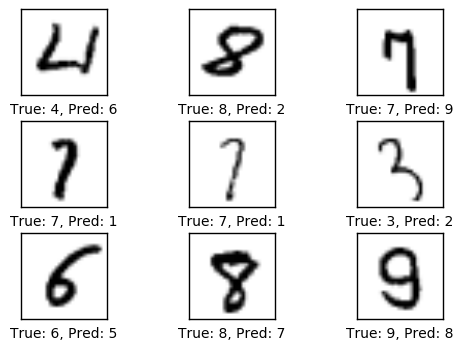

In [56]:
print_test_accuracy(show_example_errors=True)

## Performance after 100 optimization iterations

In [48]:
optimize(num_iterations=99)

Time usage:0:00:11


Accuracy on test-set:65.1%(6507/10000)
Example errors:


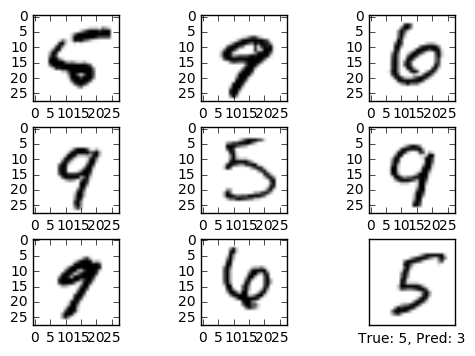

In [49]:
print_test_accuracy(show_example_errors=True)

## Performance after 1000 optimization iterations

In [50]:
optimize(num_iterations=900)

Optimization Iteration:   101,Training Accuracy: 76.6%
Optimization Iteration:   201,Training Accuracy: 73.4%
Optimization Iteration:   301,Training Accuracy: 73.4%
Optimization Iteration:   401,Training Accuracy: 84.4%
Optimization Iteration:   501,Training Accuracy: 89.1%
Optimization Iteration:   601,Training Accuracy: 95.3%
Optimization Iteration:   701,Training Accuracy: 92.2%
Optimization Iteration:   801,Training Accuracy: 92.2%
Optimization Iteration:   901,Training Accuracy: 95.3%
Time usage:0:01:41


Accuracy on test-set:93.5%(9347/10000)
Example errors:


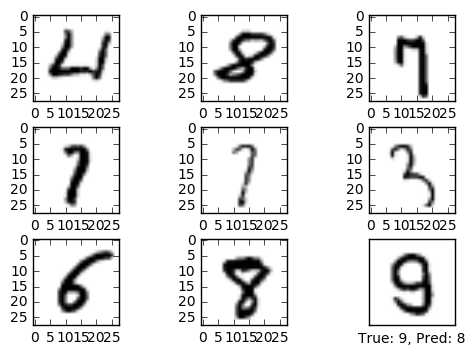

In [51]:
print_test_accuracy(show_example_errors=True)

In [57]:
optimize(num_iterations=9000)

Optimization Iteration:  1101,Training Accuracy: 95.3%
Optimization Iteration:  1201,Training Accuracy: 96.9%
Optimization Iteration:  1301,Training Accuracy: 92.2%
Optimization Iteration:  1401,Training Accuracy: 93.8%
Optimization Iteration:  1501,Training Accuracy: 95.3%
Optimization Iteration:  1601,Training Accuracy: 98.4%
Optimization Iteration:  1701,Training Accuracy: 98.4%
Optimization Iteration:  1801,Training Accuracy: 95.3%
Optimization Iteration:  1901,Training Accuracy: 95.3%
Optimization Iteration:  2001,Training Accuracy: 96.9%
Optimization Iteration:  2101,Training Accuracy: 96.9%
Optimization Iteration:  2201,Training Accuracy: 95.3%
Optimization Iteration:  2301,Training Accuracy: 98.4%
Optimization Iteration:  2401,Training Accuracy: 98.4%
Optimization Iteration:  2501,Training Accuracy: 93.8%
Optimization Iteration:  2601,Training Accuracy: 95.3%
Optimization Iteration:  2701,Training Accuracy:100.0%
Optimization Iteration:  2801,Training Accuracy: 92.2%
Optimizati

Accuracy on test-set:98.6%(9860/10000)
Example errors:


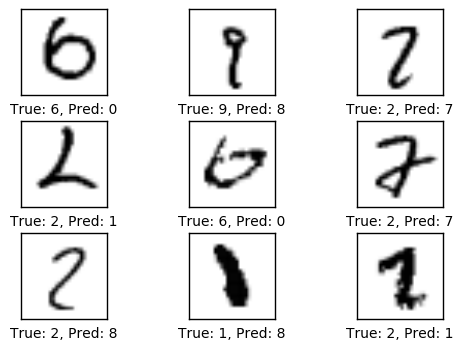

confusion matrix:
[[ 974    0    1    0    0    0    0    1    4    0]
 [   0 1127    1    0    0    0    2    0    5    0]
 [   3    4 1002   10    1    0    0    4    8    0]
 [   1    0    0 1005    0    1    0    1    2    0]
 [   0    0    0    0  978    0    0    0    1    3]
 [   1    0    0    9    0  879    1    0    2    0]
 [   8    2    0    0    5    6  937    0    0    0]
 [   1    1    2    4    0    0    0 1018    2    0]
 [   4    0    0    3    1    1    1    2  959    3]
 [   3    5    0    3    7    2    0    5    3  981]]


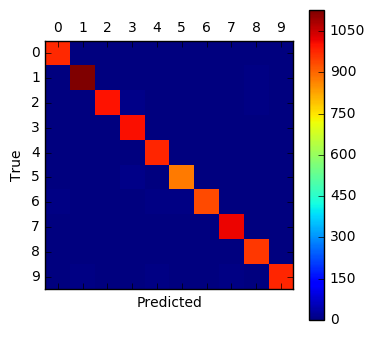

In [58]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

## Visualization of weights and layers
### Helper function for plotting convolutional weights

In [98]:
def plot_conv_weights(weights,input_channel=0):
    #Assume weights are tensorflow ops for 4-dim variabels
    #e.g.weights_conv1 or weigts_conv2
    w = session.run(weights)
    
    w_min = np.min(w)
    w_max = np.max(w)
    
    num_filters = w.shape[3]
    
    num_grids = int(math.ceil(math.sqrt(num_filters)))
    
    fig,axes = plt.subplots(num_grids,num_grids)
    
    #plot the filter weights
    for i, ax in enumerate(axes.flat):
        #only plot the valid filter weights
        if i<num_filters:
            #get the weights for the i'th filter of the input channel
            img= w[:,:,input_channel,i]
            
            ax.imshow(img,vmin=w_min,vmax=w_max,
                      interpolation='nearest',cmap='seismic')
        
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()


### Helper function for plotting the output of a convolutional layer

In [101]:
def plot_conv_layer(layer,image):
    
    feed_dict = {x:[image]}
    
    values = session.run(layer,feed_dict=feed_dict)
    
    num_filters = values.shape[3]
    
    num_grids = int(math.ceil(math.sqrt(num_filters)))
    
    fig,axes = plt.subplots(num_grids,num_grids)
    
    for i,ax in enumerate(axes.flat):
        if i<num_filters:
            img = values[0,:,:,i]
            
            ax.imshow(img,interpolation='nearest',cmap='binary')
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

In [102]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')
    plt.show()

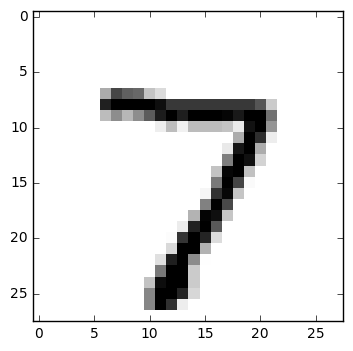

In [95]:
image1 = data.test.images[0]
plot_image(image1)

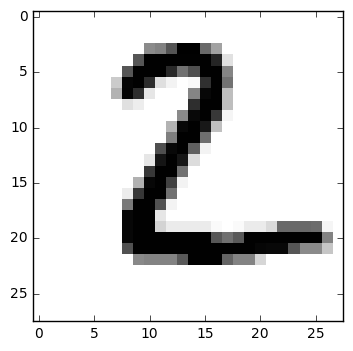

In [96]:
image2 = data.test.images[1]
plot_image(image2)

### Convolution layer

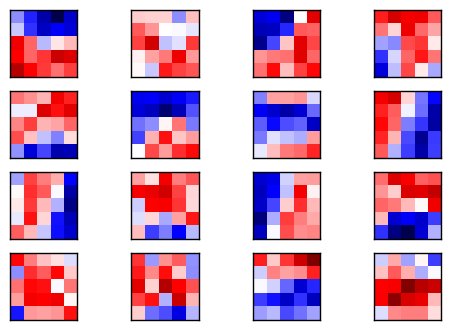

In [99]:
plot_conv_weights(weights=weights_conv1)

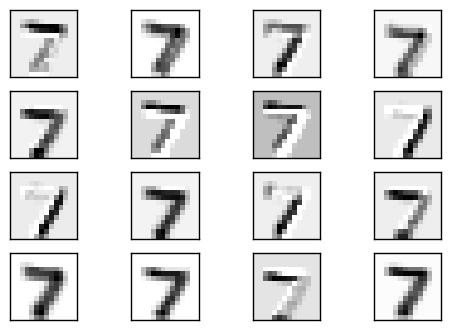

In [103]:
plot_conv_layer(layer=layer_conv1,image=image1)

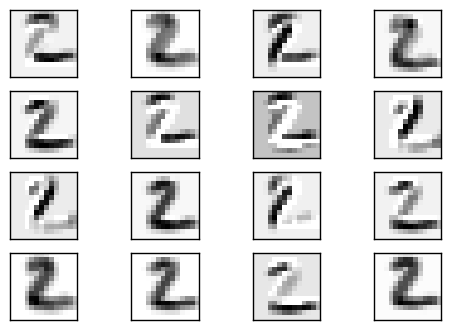

In [104]:
plot_conv_layer(layer=layer_conv1,image=image2)

### Convolution layer2

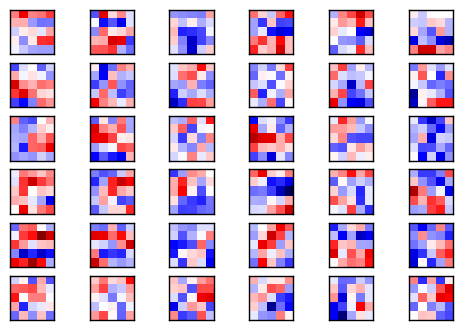

In [105]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

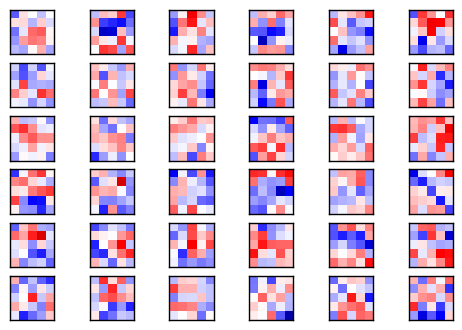

In [106]:
plot_conv_weights(weights=weights_conv2,input_channel=1)

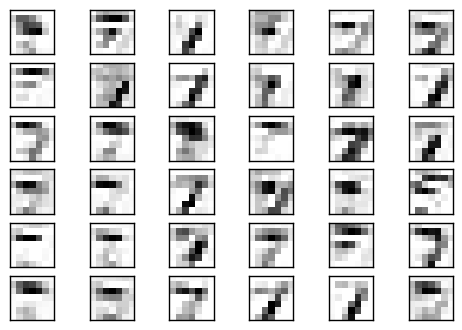

In [107]:
plot_conv_layer(layer=layer_conv2,image=image1)

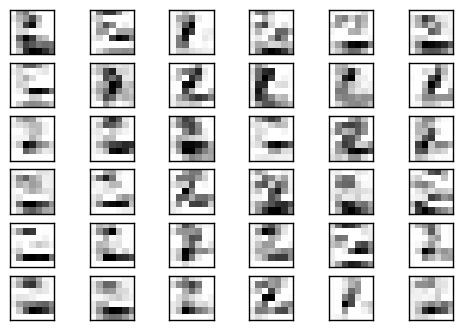

In [108]:
plot_conv_layer(layer=layer_conv2,image=image2)